In [ ]:
# WhatsAI – WhatsApp Chat NLP Intelligence System
# Dr Subramani

In [10]:
# ============================================================
# WHATAI – WHATSAPP CHAT NLP INTELLIGENCE SYSTEM (FINAL MASTER)
# ============================================================

# ---- INSTALL ONCE IF NEEDED ----------
# !pip install nltk wordcloud nrclex

import re
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from wordcloud import WordCloud, STOPWORDS
from nrclex import NRCLex


# ============================================================
# 1. LOAD RAW WHATSAPP CHAT
# ============================================================

file_path = "data/chat.txt"   # 🔁 change if needed
with open(file_path, "r", encoding="utf-8") as f:
    raw_lines = f.readlines()

print("✅ Total raw lines:", len(raw_lines))


# ============================================================
# 2. PARSE ANDROID WHATSAPP CHAT
# ============================================================

msg_pattern = re.compile(
    r'^(\d{1,2}/\d{1,2}/\d{2,4}),\s(\d{1,2}:\d{2})\s?(am|pm|AM|PM)?\s-\s(.*)$'
)

def parse_whatsapp_chat(lines):
    messages = []
    current_msg = {
        "datetime": None, "date": None, "time": None,
        "sender": None, "message": "", "is_system": False
    }

    for raw_line in lines:
        line = raw_line.strip()
        match = msg_pattern.match(line)

        if match:
            if current_msg["datetime"] is not None:
                messages.append(current_msg)
                current_msg = {
                    "datetime": None, "date": None, "time": None,
                    "sender": None, "message": "", "is_system": False
                }

            date_str, time_str, am_pm, rest = match.groups()

            if am_pm:
                dt_str = f"{date_str} {time_str} {am_pm}"
                fmts = ["%d/%m/%y %I:%M %p", "%d/%m/%Y %I:%M %p"]
            else:
                dt_str = f"{date_str} {time_str}"
                fmts = ["%d/%m/%y %H:%M", "%d/%m/%Y %H:%M"]

            dt_obj = None
            for f in fmts:
                try:
                    dt_obj = datetime.strptime(dt_str, f)
                    break
                except:
                    pass

            current_msg["datetime"] = dt_obj
            current_msg["date"] = dt_obj.date() if dt_obj else None
            current_msg["time"] = dt_obj.time() if dt_obj else None

            if ": " in rest:
                sender, msg = rest.split(": ", 1)
                current_msg["sender"] = sender.strip()
                current_msg["message"] = msg.strip()
            else:
                current_msg["sender"] = None
                current_msg["message"] = rest.strip()
                current_msg["is_system"] = True
        else:
            current_msg["message"] += " " + line

    if current_msg["datetime"] is not None:
        messages.append(current_msg)

    return pd.DataFrame(messages)

df = parse_whatsapp_chat(raw_lines)
print("✅ Parsed messages:", len(df))


# ============================================================
# 3. CLEAN DATA
# ============================================================

df = df[df["is_system"] == False]
df = df[df["sender"].notna()]
df = df[df["message"].str.strip() != ""]
df.reset_index(drop=True, inplace=True)

print("✅ Clean messages:", len(df))

df.head()

✅ Total raw lines: 53
✅ Parsed messages: 53
✅ Clean messages: 52


,datetime,date,time,sender,message,is_system
0,2019-12-05 13:42:00,2019-12-05,13:42:00,Mabel Infoziant,Hi this is Mabel we just spoke,False
1,2019-12-05 13:42:00,2019-12-05,13:42:00,Mabel Infoziant,What’s your full name,False
2,2019-12-05 13:42:00,2019-12-05,13:42:00,AR❤,Ramisha Rani K,False
3,2019-12-05 13:42:00,2019-12-05,13:42:00,Mabel Infoziant,Ok,False
4,2019-12-05 13:42:00,2019-12-05,13:42:00,Mabel Infoziant,ramisharanik@gmail.com,False


In [ ]:
# Sentiment Analysis to df

In [17]:
# ============================
# SENTIMENT ANALYSIS
# ============================

# Install NLTK VADER once (run only if not installed)
# !pip install nltk

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon (run only once)
nltk.download('vader_lexicon')

# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Apply sentiment on 'message' column
df["sentiment_scores"] = df["message"].apply(lambda x: sid.polarity_scores(str(x)))

# Split sentiment_scores dict into separate columns
df["neg"] = df["sentiment_scores"].apply(lambda x: x["neg"])
df["neu"] = df["sentiment_scores"].apply(lambda x: x["neu"])
df["pos"] = df["sentiment_scores"].apply(lambda x: x["pos"])
df["compound"] = df["sentiment_scores"].apply(lambda x: x["compound"])

# Optional: simple label based on compound score
def label_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df["sentiment_label"] = df["compound"].apply(label_sentiment)

# Quick check
print("✅ Sentiment columns added. Shape:", df.shape)
df[["datetime", "sender", "message", "neg", "neu", "pos", "compound", "sentiment_label"]].head()

✅ Sentiment columns added. Shape: (52, 13)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\15016\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,datetime,sender,message,neg,neu,pos,compound,sentiment_label
0,2019-12-05 13:42:00,Mabel Infoziant,Hi this is Mabel we just spoke,0.0,1.0,0.0,0.000,Neutral
1,2019-12-05 13:42:00,Mabel Infoziant,What’s your full name,0.0,1.0,0.0,0.000,Neutral
2,2019-12-05 13:42:00,AR❤,Ramisha Rani K,0.0,1.0,0.0,0.000,Neutral
3,2019-12-05 13:42:00,Mabel Infoziant,Ok,0.0,0.0,1.0,0.296,Positive
4,2019-12-05 13:42:00,Mabel Infoziant,ramisharanik@gmail.com,0.0,1.0,0.0,0.000,Neutral


✅ TF-IDF + NMF Model built Successfully!
✅ Topic-wise Average Sentiment:

   Topic  Average_Sentiment
0      0           0.159541
1      1           0.351180
2      2           0.073967
3      3           0.071164
4      4           0.088080

✅ Topic-wise Sentiment Distribution:

sentiment_label  Negative  Neutral  Positive
dominant_topic                              
0                       0       13         9
1                       0        0         5
2                       1        3         2
3                       2        7         5
4                       0        4         1
✅ Sentiment Distribution:

sentiment_label
Neutral     27
Positive    22
Negative     3
Name: count, dtype: int64


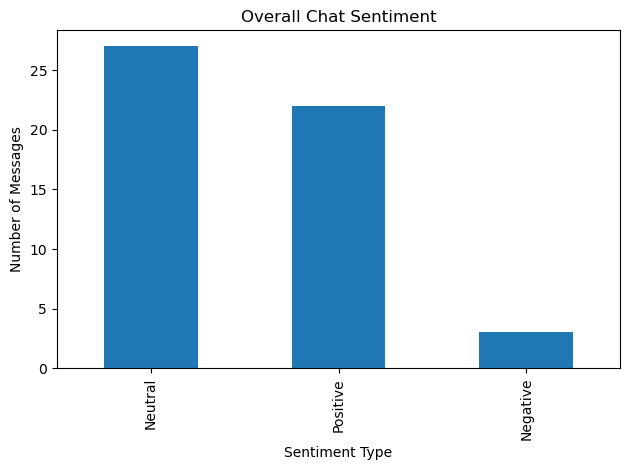

In [28]:

# ============================
# STEP : TOPIC-WISE SENTIMENT
# ============================
# ============================
# ✅ SAFETY CHECK: CREATE NMF IF NOT EXISTS
# ============================


tfidf = TfidfVectorizer(
    max_df=0.95,
    min_df=2,
    stop_words="english"
)

dtm = tfidf.fit_transform(df["message"])

nmf_model = NMF(n_components=5, random_state=42)
nmf_model.fit(dtm)
feature_names = tfidf.get_feature_names_out()

print("✅ TF-IDF + NMF Model built Successfully!")


# 1️⃣ Assign Dominant Topic to Each Message
topic_values = nmf_model.transform(dtm)
df["dominant_topic"] = topic_values.argmax(axis=1)

# 2️⃣ Group by Topic and Calculate Average Sentiment
topic_sentiment = df.groupby("dominant_topic")["compound"].mean().reset_index()
topic_sentiment.columns = ["Topic", "Average_Sentiment"]

print("✅ Topic-wise Average Sentiment:\n")
print(topic_sentiment)

# 3️⃣ Count Sentiment Labels per Topic
topic_sentiment_dist = df.groupby(
    ["dominant_topic", "sentiment_label"]
).size().unstack(fill_value=0)

print("\n✅ Topic-wise Sentiment Distribution:\n")
print(topic_sentiment_dist)

# ============================
# SIMPLE SENTIMENT BAR CHART
# ============================

# Count how many messages in each sentiment category
sentiment_counts = df["sentiment_label"].value_counts()

print("✅ Sentiment Distribution:\n")
print(sentiment_counts)

# Plot simple bar chart
plt.figure()
sentiment_counts.plot(kind="bar")
plt.title("Overall Chat Sentiment")
plt.xlabel("Sentiment Type")
plt.ylabel("Number of Messages")
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

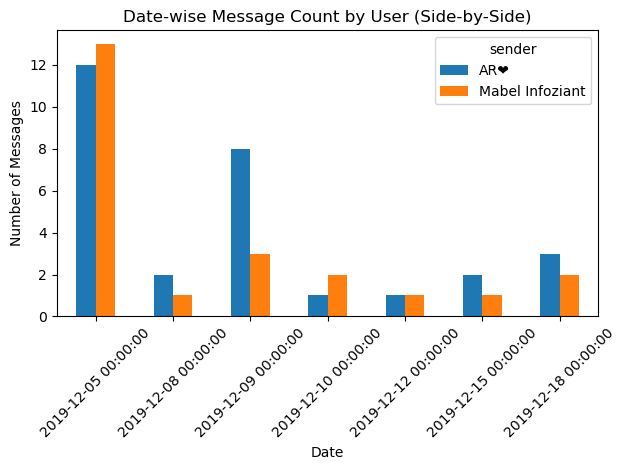

In [24]:
# ============================
# DATE-WISE MESSAGE COUNT BY USER (SIDE-BY-SIDE BAR CHART)
# ============================

# Ensure date column is datetime
df["date"] = pd.to_datetime(df["date"])

# Group by date and sender
daily_user_counts = df.groupby(["date", "sender"]).size().unstack(fill_value=0)

# Plot SIDE-BY-SIDE (grouped) bar chart
plt.figure()
daily_user_counts.plot(kind="bar")

plt.title("Date-wise Message Count by User (Side-by-Side)")
plt.xlabel("Date")
plt.ylabel("Number of Messages")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [29]:
# ============================
# TIME & MEDIA ENCOUNTERS SUMMARY
# ============================

# Ensure datetime and date columns are datetime type
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# ----------------------------
# ⏰ TIME ENCOUNTERS
# ----------------------------

# Most Active Date
most_active_date = df["date"].value_counts().idxmax()

# Most Active Day Name (Monday, Tuesday, etc.)
most_active_day = df["date"].dt.day_name().value_counts().idxmax()

# Most Active Hour
most_active_hour = df["datetime"].dt.hour.value_counts().idxmax()

# Average Number of Messages per Day
avg_messages_per_day = df.groupby("date").size().mean()

# ----------------------------
# 📁 MEDIA & SYSTEM ENCOUNTERS
# ----------------------------

# Media Count (images, videos, audio)
media_count = df["message"].str.contains(
    r"<Media omitted>|image omitted|video omitted|audio omitted|IMG-|VID-|AUD-",
    case=False,
    na=False
).sum()

# Deleted Message Count
deleted_message_count = df["message"].str.contains(
    r"deleted this message|message was deleted",
    case=False,
    na=False
).sum()

# Missed Voice Call Count
missed_voice_call_count = df["message"].str.contains(
    r"missed voice call",
    case=False,
    na=False
).sum()

# Missed Video Call Count
missed_video_call_count = df["message"].str.contains(
    r"missed video call",
    case=False,
    na=False
).sum()

# ----------------------------
# ✅ DISPLAY LIKE DASHBOARD
# ----------------------------

print("🕒 TIME ENCOUNTERS:")
print(f"Most Active Date: {most_active_date.date()}")
print(f"Most Active Day: {most_active_day}")
print(f"Most Active Hour: {most_active_hour}:00")
print(f"Average Messages per Day: {round(avg_messages_per_day, 2)}")

print("\n📁 MEDIA ENCOUNTERS:")
print(f"Media Count: {media_count}")
print(f"Deleted Message Count: {deleted_message_count}")
print(f"Missed Voice Call Count: {missed_voice_call_count}")
print(f"Missed Video Call Count: {missed_video_call_count}")

🕒 TIME ENCOUNTERS:
Most Active Date: 2019-12-05
Most Active Day: Thursday
Most Active Hour: 13:00
Average Messages per Day: 7.43

📁 MEDIA ENCOUNTERS:
Media Count: 0
Deleted Message Count: 1
Missed Voice Call Count: 0
Missed Video Call Count: 0


💘 FLIRT ENCOUNTERS:

Talkative: AR❤
Less Talkative: Mabel Infoziant

Flirt Percentage by AR❤: 6.9
Flirt Percentage by Mabel Infoziant: 13.04


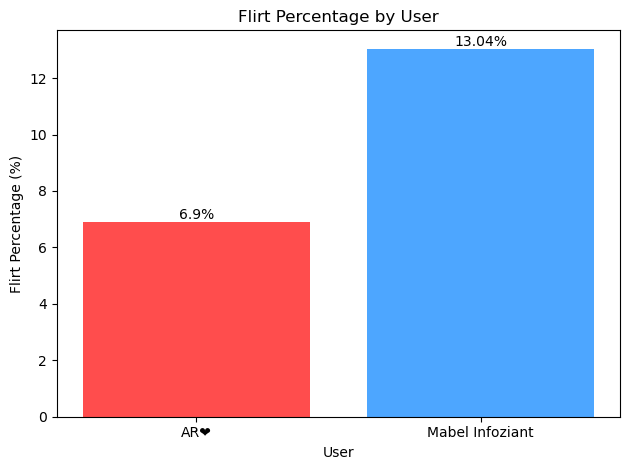

In [30]:
# ============================
# FLIRT ENCOUNTERS - SINGLE FULL CODE
# ============================

# ============================
# EXTENDED FLIRT KEYWORDS LIST (120+)
# ============================

flirt_keywords = [

    # ❤️ Romantic Words
    "love", "lovely", "loving", "lover", "lovers", "romantic", "romance",
    "my love", "my life", "my heart", "heart", "heartbeat",

    # 😘 Kisses & Hugs
    "kiss", "kissing", "kissed", "hug", "hugs", "hugging", "tight hug",
    "flying kiss", "forehead kiss", "virtual kiss",

    # 💕 Pet Names
    "baby", "babe", "jaan", "shona", "sona", "sweetheart", "sweetie",
    "darling", "dear", "angel", "honey", "cutie", "cutest", "pumpkin",

    # 💖 Compliments
    "cute", "cutiepie", "gorgeous", "beautiful", "pretty", "hot",
    "handsome", "sexy", "charming", "stunning", "attractive",

    # 😍 Attraction
    "miss you", "missing you", "need you", "want you", "crushing",
    "crush", "my crush", "blushing", "is it love",

    # 💞 Relationship Words
    "forever", "together", "soulmate", "life partner", "valentine",
    "boyfriend", "girlfriend", "hubby", "wifey", "partner",

    # 🥰 Emotions
    "feelings", "emotional", "attached", "obsessed", "addicted to you",
    "can't live without you", "i adore you",

    # 💋 Physical Attraction
    "lip kiss", "cheek kiss", "hold my hand", "hold you", "touch you",

    # 😏 Flirty Expressions
    "hey you", "come here", "naughty", "wink", "flirting", "flirt",
    "smooth talk", "pick up line",

    # 💌 Romantic Phrases
    "thinking about you", "dreaming of you", "you are mine",
    "mine forever", "only mine", "just us",

    # ❤️ Emojis
    "😍", "😘", "❤️", "💋", "💕", "💖", "💗", "💓", "💞", "💘", "💝",
    "🥰", "😚", "😻", "👩‍❤️‍👨", "👩‍❤️‍💋‍👨", "👩‍❤️‍💋‍👩", "🔥",

    # 🫶 Extra Indian Style Flirt
    "jaaneman", "merijaan", "meri jaan", "dil", "dilruba",
    "mehbooba", "sanam", "sajna", "piya", "raja", "rani",

    # 💑 Cute Chat Slang
    "luv u", "love u", "miss u", "xoxo", "muah", "mwah", "ummma",
    "babyboo", "babygirl", "babyboy"
]

# 2️⃣ FLIRT MESSAGE DETECTION FUNCTION
def is_flirt(text):
    text = str(text).lower()
    return any(word in text for word in flirt_keywords)

# Apply flirt detection
df["is_flirt"] = df["message"].apply(is_flirt)

# 3️⃣ TALKATIVE & LESS TALKATIVE USERS
user_message_counts = df["sender"].value_counts()

most_talkative = user_message_counts.idxmax()
least_talkative = user_message_counts.idxmin()

# 4️⃣ FLIRT PERCENTAGE BY EACH USER
flirt_stats = (df.groupby("sender")["is_flirt"].mean() * 100).round(2)

# 5️⃣ FINAL FLIRT ENCOUNTERS OUTPUT (LIKE IMAGE)
print("💘 FLIRT ENCOUNTERS:\n")

print(f"Talkative: {most_talkative}")
print(f"Less Talkative: {least_talkative}\n")

for user, percent in flirt_stats.items():
    print(f"Flirt Percentage by {user}: {percent}")


# ============================
# FLIRT PERCENTAGE BAR CHART
# ============================

# Convert flirt_stats to DataFrame for plotting
flirt_df = flirt_stats.reset_index()
flirt_df.columns = ["User", "Flirt_Percentage"]

# ============================
# FLIRT PERCENTAGE BAR CHART (DIFFERENT COLORS)
# ============================

# Convert flirt_stats to DataFrame for plotting
flirt_df = flirt_stats.reset_index()
flirt_df.columns = ["User", "Flirt_Percentage"]

# Create different colors for each bar
colors = ["#ff4d4d", "#4da6ff", "#33cc99", "#ffcc00", "#cc66ff"]  

# Plot bar chart
plt.figure()
plt.bar(
    flirt_df["User"],
    flirt_df["Flirt_Percentage"],
    color=colors[:len(flirt_df)]  # auto-adjust to number of users
)

plt.title("Flirt Percentage by User")
plt.xlabel("User")
plt.ylabel("Flirt Percentage (%)")

# Show percentage values on top of bars
for i, value in enumerate(flirt_df["Flirt_Percentage"]):
    plt.text(i, value, f"{value}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()




🟢 Topic 1 - Top 10 Words:
['details', 'soon', 'ask', 'yes', 'sure', 'read', 'abstract', 'kk', 'yeah', 'mam']

🟢 Topic 2 - Top 10 Words:
['yes', 'just', 'finiliaze', 'send', 'know', 'think', 'tomorrow', 'number', 'mam', 'ok']

🟢 Topic 3 - Top 10 Words:
['yes', 'soon', 'mam', 'abstracts', 'vignesh', 'think', 'details', 'finiliaze', 'sent', 'project']

🟢 Topic 4 - Top 10 Words:
['ml', 'phone', 'students', 'need', 'ask', 'details', 'office', 'vignesh', 'number', 'send']

🟢 Topic 5 - Top 10 Words:
['share', 'yeah', 'yes', 'mam', 'office', 'know', 'just', 'tomorrow', 'church', 'hi']


C:\Anaconda3\envs\ssai\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


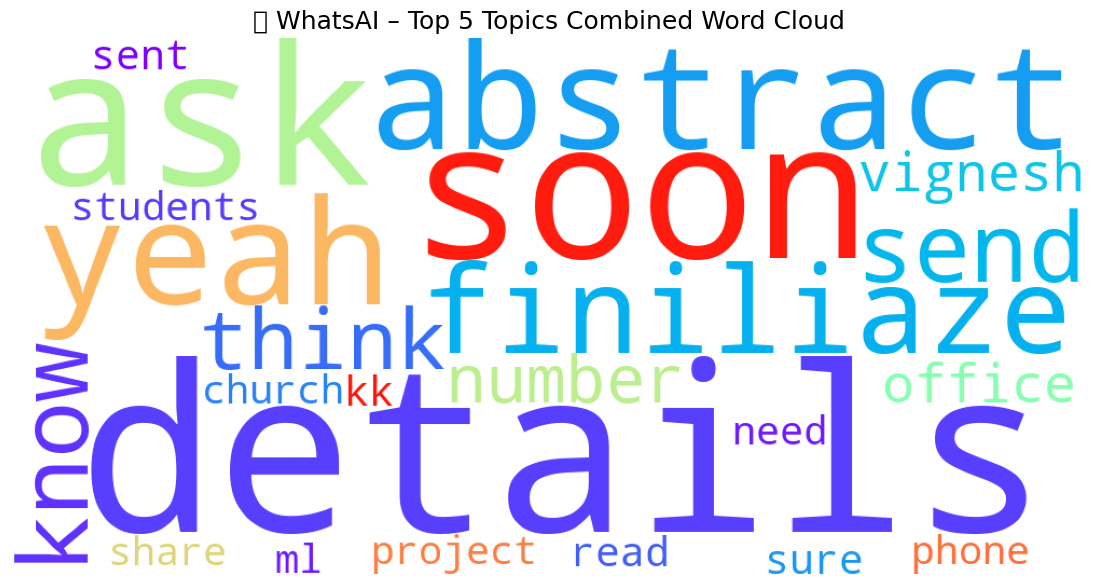

In [31]:
# ============================
# TOP 5 TOPICS → TOP 10 WORDS EACH → ONE WORD CLOUD
# ============================

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# ✅ How many topics & words you want
NUM_TOPICS = 5
WORDS_PER_TOPIC = 10

all_top_words = []

# 1️⃣ Extract Top 10 Words from Each of Top 5 Topics
for topic_index in range(NUM_TOPICS):
    topic = nmf_model.components_[topic_index]
    
    top_word_idx = topic.argsort()[-WORDS_PER_TOPIC:]
    top_words = [feature_names[i] for i in top_word_idx]
    
    print(f"\n🟢 Topic {topic_index + 1} - Top {WORDS_PER_TOPIC} Words:")
    print(top_words)
    
    all_top_words.extend(top_words)

# 2️⃣ Convert all selected words into one clean text
final_text = " ".join(all_top_words)

# 3️⃣ Custom stopwords (extra cleaning)
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    "ok", "okay", "yes", "no", "hi", "hello", "today", "tomorrow",
    "bro", "sir", "mam", "maam", "pls", "please", "u", "ur"
])

# 4️⃣ Generate ONE WordCloud from Top 5 Topic Words
wc = WordCloud(
    width=1000,
    height=500,
    background_color="white",
    stopwords=custom_stopwords,
    colormap="rainbow",
    max_words=50,
    contour_width=2,
    contour_color="black"
).generate(final_text)

# 5️⃣ Display WordCloud
plt.figure(figsize=(14, 7))
plt.imshow(wc)
plt.axis("off")
plt.title("🌈 WhatsAI – Top 5 Topics Combined Word Cloud", fontsize=18)
plt.show()


In [33]:
# ------------------------------------------------------------
#  ADVANCED FILTERS + AI INSIGHT GENERATOR
# ------------------------------------------------------------

def filter_by_user(df_in, user):
    if user is None or user == "All":
        return df_in
    return df_in[df_in["sender"] == user]

def filter_by_date_range(df_in, start_date=None, end_date=None):
    temp = df_in.copy()
    if start_date:
        temp = temp[temp["date"] >= pd.to_datetime(start_date).date()]
    if end_date:
        temp = temp[temp["date"] <= pd.to_datetime(end_date).date()]
    return temp

def filter_by_keyword(df_in, keyword=None):
    if keyword is None or keyword.strip() == "":
        return df_in
    return df_in[df_in["message"].str.contains(keyword, case=False, na=False)]

def generate_ai_insights(df_in):
    insights = []
    if df_in.empty:
        return ["No messages available for insights."]

    # Most active user
    try:
        top_user = df_in["sender"].value_counts().idxmax()
        insights.append(f"👤 Most active user: {top_user}")
    except:
        pass

    # Overall sentiment
    try:
        sentiment_summary = df_in["sentiment_label"].value_counts().idxmax()
        insights.append(f"😊 Overall chat mood: {sentiment_summary}")
    except:
        pass

    # Most discussed topic
    if "dominant_topic" in df_in.columns:
        try:
            top_topic = df_in["dominant_topic"].value_counts().idxmax()
            insights.append(f"🧠 Most discussed topic: Topic {top_topic}")
        except:
            pass

    # Most common emotion
    try:
        top_emotion = df_in["emotion"].value_counts().idxmax()
        insights.append(f"❤️ Most common emotion: {top_emotion}")
    except:
        pass

    # Peak chat hour
    try:
        # convert time to string hour "HH"
        hour_series = df_in["time"].astype(str).str[:2]
        peak_hour = hour_series.value_counts().idxmax()
        insights.append(f"⏰ Peak chatting hour: {peak_hour}:00")
    except:
        pass

    return insights

# Example usage on full data
df_filtered = filter_by_user(df, "All")
df_filtered = filter_by_keyword(df_filtered, None)
df_filtered = filter_by_date_range(df_filtered, None, None)

ai_insights = generate_ai_insights(df_filtered)

print("\n✅ AI AUTO INSIGHTS:\n")
for ins in ai_insights:
    print("•", ins)


# ------------------------------------------------------------
# 8. SAVE FINAL DATAFRAME FOR STREAMLIT / FURTHER USE
# ------------------------------------------------------------

df.to_csv("whatsapp_final.csv", index=False)
print("\n✅ Final data saved to whatsapp_final.csv")



✅ AI AUTO INSIGHTS:

• 👤 Most active user: AR❤
• 😊 Overall chat mood: Neutral
• 🧠 Most discussed topic: Topic 0
• ⏰ Peak chatting hour: 13:00

✅ Final data saved to whatsapp_final.csv
